In [1]:
import pickle
import argparse
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import glob

from main import main

In [33]:
# Loading metrics from saved pickles
metrics = {}
for m in glob.glob("runs/*/*/metrics.pkl"):
    run = m.split('/')[1]
    if run not in metrics:
        metrics[run] = {}
    seed = m.split('/')[2]
    metrics[run][seed] = pickle.load(open(m, 'rb'))

## Run Iterated Learning Base Experiments

In [ ]:
#LSTM
seeds = [41, 42, 43, 44, 45]

metrics = {'lstm': {}, 'gru': {}}
for s in seeds:
    metrics['lstm'][s] = main(['--seed', str(s), '--iterations', '1000', '--generations', '50'])
for s in seeds:
    metrics['gru'][s] = main(['--seed', str(s), '--iterations', '1000', '--model-type', 'gru', '--generations', '50'])

Meaning Space Length: 162
0/1000 Iterations: val loss: 3.331641674041748, val accuracy: 0.09486166387796402
200/1000 Iterations: val loss: 3.2632906436920166, val accuracy: 0.12252964824438095
400/1000 Iterations: val loss: 3.258121967315674, val accuracy: 0.12648221850395203
600/1000 Iterations: val loss: 3.258357286453247, val accuracy: 0.12648221850395203
800/1000 Iterations: val loss: 3.2568016052246094, val accuracy: 0.12648221850395203
1000/1000 Iterations: val loss: 3.2596499919891357, val accuracy: 0.11857707798480988
0/1000 Iterations: val loss: 3.3297970294952393, val accuracy: 0.0988142341375351
200/1000 Iterations: val loss: 3.0633702278137207, val accuracy: 0.3399209678173065
400/1000 Iterations: val loss: 2.9655637741088867, val accuracy: 0.43478262424468994
600/1000 Iterations: val loss: 2.9523651599884033, val accuracy: 0.4387351870536804
800/1000 Iterations: val loss: 2.957716226577759, val accuracy: 0.4426877498626709
1000/1000 Iterations: val loss: 2.954284906387329,

In [3]:
metrics['lstm'][42][0]

{'validation_loss': {0: 3.3312413692474365,
  200: 3.272643566131592,
  400: 3.2582666873931885,
  600: 3.2548375129699707,
  800: 3.24068284034729,
  1000: 3.252091646194458},
 'validation_acc': {0: 0.09090909361839294,
  200: 0.11067193746566772,
  400: 0.13438735902309418,
  600: 0.13438735902309418,
  800: 0.1462450623512268,
  1000: 0.14229249954223633},
 'total_distance': 0.7469135802469136,
 'perfect_matches': 0.0,
 'jaccard_sim': 0.12483321108339485,
 'num_unique_messages': 159,
 'test_loss': 3.2618069648742676,
 'test_acc': 0.11564171314239502,
 'topographic_similarity': 0.31607491616154837}

### Plot Results

In [4]:
def plot_metric(results, metric="test_loss", ylabel=None, show_error=True, 
                savefig=True, figname=None, title=None, ylim=None, a4_dims=(11.7, 8.27)):
    
    ci = 'sd' if show_error else None
    fig, ax = plt.subplots(figsize=a4_dims)
    
    generations = []
    values = []
    run_names = []
    
    for r in list(results.keys()):
        for s in list(results[r].keys()):    
            for g in sorted(list(results[r][s].keys())):
                generations.append(g)
                values.append(results[r][s][g][metric])
                run_names.append(r)
            
    values = np.array(values)
    iterations = np.array(generations)   
      
    d = {'Generations': iterations,'': run_names, metric: values}
    ax = sns.lineplot(ax=ax, x='Generations', y=metric, data=pd.DataFrame(data=d), style='', hue='', ci=ci, palette='colorblind')
    if title is None:
        title = metric.replace('_', ' ').title()
    ax.set_title(title, fontsize=30)
    plt.show()

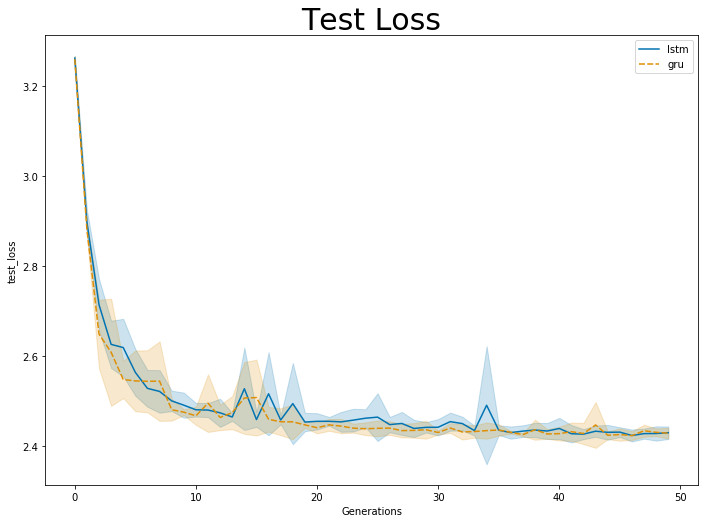

In [12]:
plot_metric(metrics)

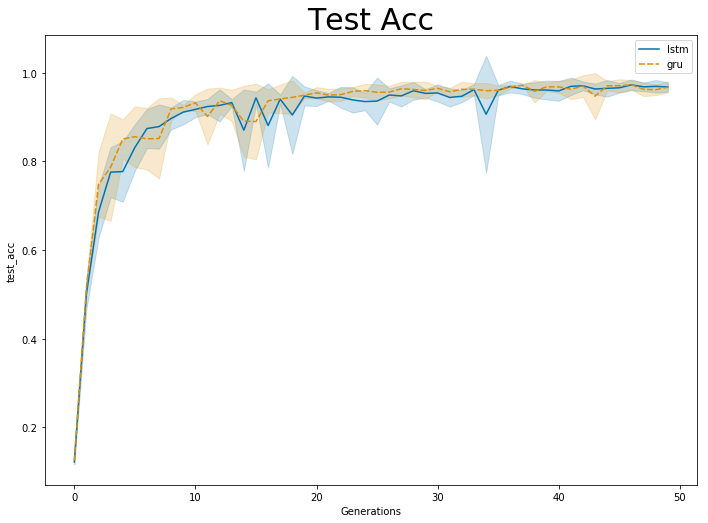

In [13]:
plot_metric(metrics, metric='test_acc')

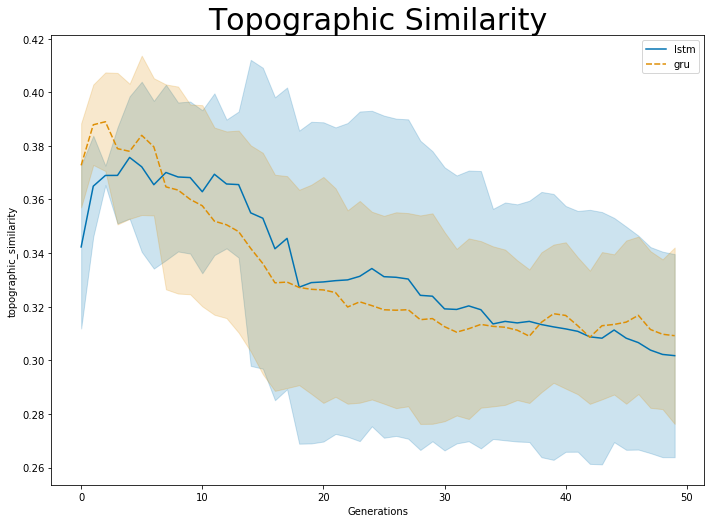

In [14]:
plot_metric(metrics, metric='topographic_similarity')

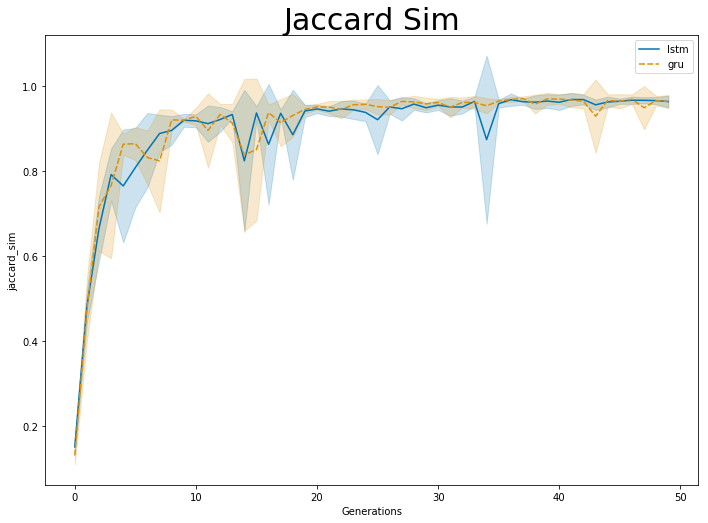

In [15]:
plot_metric(metrics, metric='jaccard_sim')

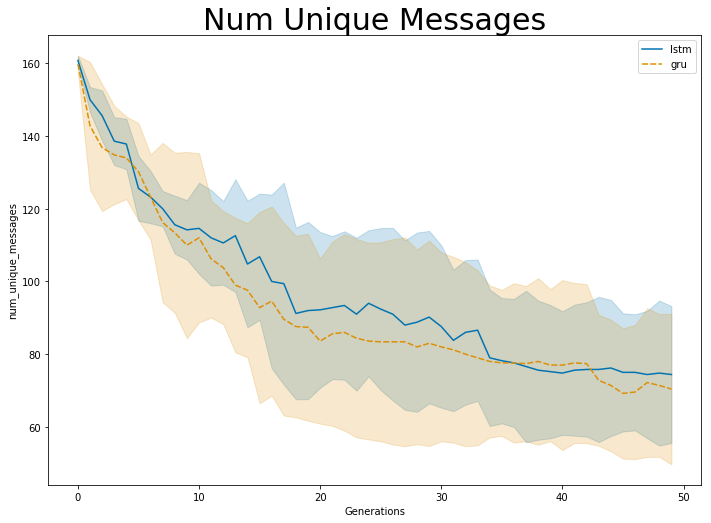

In [17]:
plot_metric(metrics, metric='num_unique_messages')